In [7]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from IPython.display import display
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from transformers import TextStreamer
from unsloth import FastVisionModel  # FastLanguageModel for LLMs

In [11]:
# Hyperparameters
SECONDS_BEFORE = 0.5  # number of seconds before the collision for image frame.

In [9]:
PROJECT_DIR = "nexcar-challenge"
DATA_DIR = "data"

train_csv_path = f"/content/drive/MyDrive/{PROJECT_DIR}/{DATA_DIR}/train.csv"
train_videos_folder = f"/content/drive/MyDrive/{PROJECT_DIR}/{DATA_DIR}/train/"

df = pd.read_csv(train_csv_path)
# df = df[df['target']==1]
df.head()

,id,time_of_event,time_of_alert,target
0,1924,NaN,NaN,0
1,822,19.5,18.633,1
2,1429,NaN,NaN,0
3,208,19.8,19.233,1
4,1904,NaN,NaN,0


In [12]:
class ImageDataset(Dataset):
    def __init__(self, data, videos_folder, transform=None):
        self.data = data
        self.videos_folder = videos_folder
        self.transform = transform  # Any image transformations (e.g., augmentations)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        vid_path = os.path.join(
            self.videos_folder, f"{str(int(row['id'])).zfill(5)}.mp4"
        )

        time = (
            0.0
            if np.isnan(row["time_of_event"])
            else row["time_of_event"] - SECONDS_BEFORE
        )
        image = self.get_frame(vid_path, time)

        label = row["target"]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), row['id']  # Convert label to tensor

    def get_frame(self, video_path, time_sec):
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, time_sec * 1000)

        success, frame = cap.read()
        cap.release()

        if not success:
            raise ValueError(f"Failed to read frame at {time_sec} seconds.")

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(frame)


transform = transforms.Compose(
    [
        transforms.Resize((480, 854)),  # Resize to a standard size
    ]
)

dataset = ImageDataset(df, train_videos_folder, transform=transform)
dataloader = DataLoader(dataset, shuffle=True)

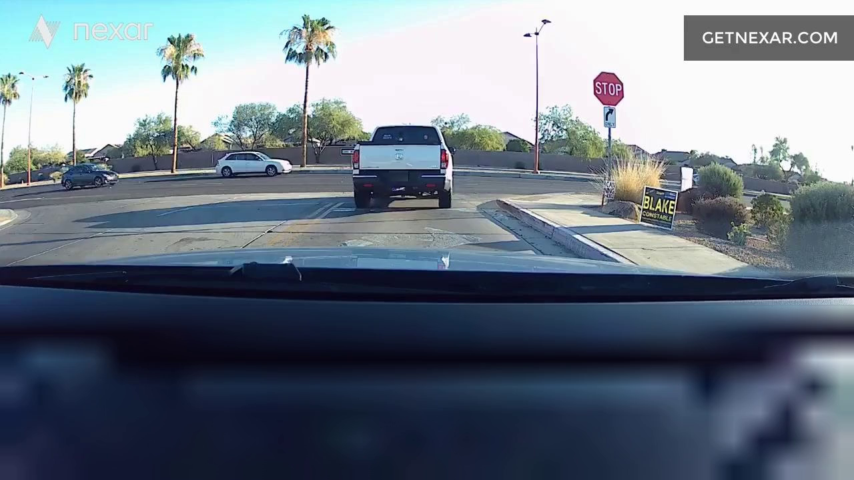

tensor(0., dtype=torch.float64)


In [13]:
image, label, _ = dataset[0]
display(image)
print(label)

In [14]:
instruction = """Examine the provided dashcam image and analyze the positions and trajectories of all visible vehicles and obstacles. Based solely on the visual cues in the image, determine if there is an imminent risk of collision. Answer with only "Yes" or "No"."""


def convert_to_conversation(image, label):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": image},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": "Yes" if label else "No"}],
        },
    ]
    return {"messages": conversation}


converted_dataset = [
    convert_to_conversation(image, label) for image, label, _ in tqdm(dataset)
]

100%|██████████| 1500/1500 [23:59<00:00,  1.04it/s]


In [15]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Examine the provided dashcam image and analyze the positions and trajectories of all visible vehicles and obstacles. Based solely on the visual cues in the image, determine if there is an imminent risk of collision. Answer with only "Yes" or "No".'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=854x480>}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}]}

In [4]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab and Kaggle notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [10]:
model, tokenizer = FastVisionModel.from_pretrained(
    f"/content/drive/MyDrive/{PROJECT_DIR}/pretrained/finetuned_llama/",
    load_in_4bit=False,  # Use 4bit to reduce memory use. False for 16bit LoRA.
    # use_gradient_checkpointing="unsloth",  # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.5: Fast Mllama vision patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
FastVisionModel.for_inference(model)  # Enable for inference!

image, label, _ = dataset[0]
conversation = convert_to_conversation(image, label)

input_text = tokenizer.apply_chat_template(
    conversation["messages"], add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")


text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

Based on the provided dashcam image, I analyze the positions and trajectories of all visible vehicles and obstacles. I observe that the positions and trajectories of all visible vehicles and obstacles do not indicate an imminent risk of collision. Therefore, I conclude that there is no imminent risk of collision.

Answer: No<|eot_id|>


In [21]:
FastVisionModel.for_inference(model)  # Enable for inference!

image, label, _ = dataset[0]
conversation = convert_to_conversation(image, label)

input_text = tokenizer.apply_chat_template(
    conversation["messages"], add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")


text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

Analysis of the provided dashcam image reveals the following visual cues:

* The positions and trajectories of all visible vehicles and obstacles are clearly visible.
* There are no visible signs of collision or imminent risk of collision.

Based solely on the visual cues in the image, it is determined that there is no imminent risk of collision.<|eot_id|>


In [ ]:
correct = 0
total = len(dataset)

for i, (image, target, _) in enumerate(tqdm(dataset)):
    conversation = convert_to_conversation(image, label)
    input_text = tokenizer.apply_chat_template(
        conversation["messages"], add_generation_prompt=True
    )
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # Generate output and decode text
    output_tokens = model.generate(
        **inputs, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1
    )
    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True).lower()

    # Evaluate the output:
    if (target == 1 and "yes" in output_text.lower()) or (
        target != 1 and "no" in output_text.lower()
    ):
        correct += 1

accuracy = correct / total
print("Accuracy:", accuracy)

In [ ]:
test_csv_path = f"/content/drive/MyDrive/{PROJECT_DIR}/{DATA_DIR}/test.csv"
test_videos_folder = f"/content/drive/MyDrive/{PROJECT_DIR}/{DATA_DIR}/test/"
test_set = ImageDataset(df, train_videos_folder, transform=transform)

In [ ]:
results = []

for image, target, id in test_set:
    conversation = convert_to_conversation(image, label)
    input_text = tokenizer.apply_chat_template(
        conversation["messages"], add_generation_prompt=True
    )

    # Tokenize the image and text inputs and move them to CUDA.
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    output_tokens = model.generate(
        **inputs, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1
    )

    target = 1 if "yes" in output_text.lower() else 0
    results.append({"id": id, "target": target})

df = pd.DataFrame(results)
df.to_csv("test_results.csv", index=False)
print("Test set results saved to 'test_results.csv'")